In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
df = pd.read_csv("super_rugby_oddsportal.csv").drop('Play-off Game?', axis=1).dropna()

In [5]:
spare = pd.read_csv("super_rugby_oddsportal.csv").drop('Play-off Game?', axis=1).dropna()

In [11]:
df.head(6)

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,5-Apr-19,Highlanders,Hurricanes,0.0,0.0,2.22,21.36,1.68,11.0
1,5-Apr-19,Reds,Stormers,0.0,0.0,1.92,21.36,1.90,11.0
2,5-Apr-19,Lions,Sharks,0.0,0.0,1.38,22.93,3.08,11.0
3,6-Apr-19,Crusaders,Brumbies,0.0,0.0,1.03,41.75,11.32,11.0
4,6-Apr-19,Blues,Waratahs,0.0,0.0,1.34,23.58,3.34,11.0
5,6-Apr-19,Rebels,Sunwolves,0.0,0.0,1.16,29.75,5.14,11.0


### Get win streak

In [29]:
def bool_to_int(bool_val):
    if bool_val:
        return 1
    else:
        return -1

def get_home_streak(team, date):
    
    date_df = df[df['Date'] < date]
    team_df = date_df[date_df['Home Team']==team].sort_values('Date', ascending=False)
    results = team_df.itertuples()
    try: 
        last_result = bool_to_int(next(results)[-1])
        streak = last_result
    except:
        streak = 0
    
    while True:
        try:
            next_result = bool_to_int(next(results)[-1])
            if next_result == last_result:
                streak += next_result
            else:
                break
        except:
            break
    
    return streak
        

def get_away_streak(team, date):
    
    date_df = df[df['Date'] < date]
    team_df = date_df[date_df['Away Team']==team].sort_values('Date', ascending=False)
    results = team_df.itertuples()
    try:
        last_result = bool_to_int(next(results)[-1])*-1
        streak = last_result
    except:
        streak = 0
    
    while True:
        try:
            next_result = bool_to_int(next(results)[-1])*-1
            if next_result == last_result:
                streak += next_result
            else:
                break
        except:
            break
    
    return streak

### Cleaning and Feature Engineering

In [30]:
countries = {'Crusaders': 'NZ',
             'Chiefs': 'NZ',
             'Blues': 'NZ',
             'Hurricanes': 'NZ',
             'Highlanders': 'NZ',
             'Bulls': 'SA',
             'Cheetahs': 'SA',
             'Kings': 'SA',
             'Lions': 'SA',
             'Sharks': 'SA',
             'Stormers': 'SA',
             'Brumbies': 'AUS',
             'Force': 'AUS',
             'Rebels': 'AUS',
             'Reds': 'AUS',
             'Waratahs': 'AUS',
             'Jaguares': 'ARG',
             'Sunwolves': 'JPN'}

def cleanup(df):
    
    # convert Date to datetime
    df['Date'] = pd.to_datetime(df.Date)
    
    # create response variable
    df['home_margin'] = df['Home Score'] - df['Away Score']
    
    # create home_win column
    df['home_win'] = (df['Home Score'] > df['Away Score'])
    
    df.drop(['Home Score', 'Away Score'], axis=1, inplace=True)
    
    # create home_streak and away_streak columns
    home_streaks = []
    away_streaks = []
    for row in df.itertuples():
        home_team = row[2]
        away_team = row[3]
        date = row[1]
        home_streaks.append(get_home_streak(home_team, date))
        away_streaks.append(get_away_streak(away_team, date))
        
    df['home_streak'] = home_streaks
    df['away_streak'] = away_streaks
    
    # add nationalities
    df['home_nationality'] = df['Home Team'].replace(countries)
    df['away_nationality'] = df['Away Team'].replace(countries)
    
    # encode nationalities
    df = pd.get_dummies(df, prefix='home_country', columns=['home_nationality'])
    df = pd.get_dummies(df, prefix='away_country', columns=['away_nationality'])
    
    # encode team names
    df = pd.get_dummies(df, prefix='home_team', columns=['Home Team'])
    df = pd.get_dummies(df, prefix='away_team', columns=['Away Team'])
    
    # aggregate odds into single probability variable
    df['home_odds'] = df['Away Odds'] / (df['Home Odds'] + df['Away Odds'])
    
    # drop irrelevent columns
    df.drop(['Date', 'Home Odds', 'Draw Odds', 'Away Odds', 'Bookmakers Surveyed',
             'home_country_ARG', 'home_country_JPN', 'away_country_ARG',
             'away_country_JPN', 'home_team_Cheetahs', 'away_team_Cheetahs',
             'home_team_Kings', 'away_team_Kings', 'home_team_Force',
             'away_team_Force'], 
            axis=1,
            inplace=True)
    
    return df

In [31]:
df = cleanup(df)
df.head(15)

,home_margin,home_win,home_streak,away_streak,home_country_AUS,home_country_NZ,home_country_SA,away_country_AUS,away_country_NZ,away_country_SA,...,away_team_Hurricanes,away_team_Jaguares,away_team_Lions,away_team_Rebels,away_team_Reds,away_team_Sharks,away_team_Stormers,away_team_Sunwolves,away_team_Waratahs,home_odds
0,0.0,False,-2,-1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0.294372
1,0.0,False,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.515544
2,0.0,False,2,-4,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0.685393
3,0.0,False,-2,-8,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0.568878
4,0.0,False,2,8,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.283898
5,0.0,False,1,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0.701099
6,3.0,True,11,-1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.740443
7,3.0,True,1,-1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.610422
8,29.0,True,21,-2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.826807
9,8.0,True,-1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.818466


In [9]:
import seaborn as sns

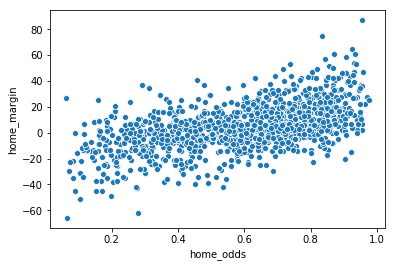

In [10]:
sns.scatterplot(x='home_odds', y='home_margin', data=df)

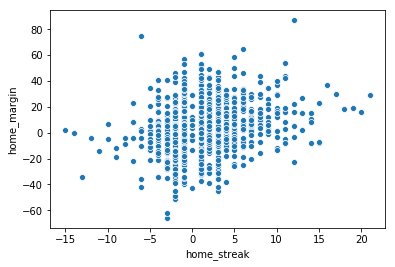

In [11]:
sns.scatterplot(x='home_streak', y='home_margin', data=df)

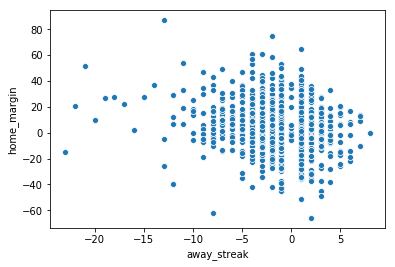

In [12]:
sns.scatterplot(x='away_streak', y='home_margin', data=df)

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
home_margin,1240.0,4.541129,17.310904,-66.000000,-6.000000,5.000000,15.000000,87.000000
home_streak,1240.0,1.190323,3.812079,-15.000000,-1.000000,1.000000,3.000000,21.000000
away_streak,1240.0,-1.151613,3.428210,-23.000000,-3.000000,-1.000000,1.000000,8.000000
home_country_AUS,1240.0,0.297581,0.457379,0.000000,0.000000,0.000000,1.000000,1.000000
home_country_NZ,1240.0,0.329032,0.470051,0.000000,0.000000,0.000000,1.000000,1.000000
home_country_SA,1240.0,0.331452,0.470925,0.000000,0.000000,0.000000,1.000000,1.000000
away_country_AUS,1240.0,0.299194,0.458090,0.000000,0.000000,0.000000,1.000000,1.000000
away_country_NZ,1240.0,0.333871,0.471785,0.000000,0.000000,0.000000,1.000000,1.000000
away_country_SA,1240.0,0.325806,0.468864,0.000000,0.000000,0.000000,1.000000,1.000000
home_team_Blues,1240.0,0.063710,0.244334,0.000000,0.000000,0.000000,0.000000,1.000000


### TO DO: Engineer more features which capture form, attack, defense etc
Would like to create a function that finds the last 5 fixtures for each team, or something along those lines.

In [14]:
X = df[6:].drop(['home_margin', 'home_win'], axis=1)
y = df[6:].home_margin.values

In [15]:
# we will use these later:
X_temp = df[:6].drop(['home_margin', 'home_win'], axis=1)
y_temp = df[:6].home_margin.values

In [16]:
y.shape

(1234,)

In [17]:
X.shape

(1234, 39)

### TPOT

In [36]:
from tpot import TPOTRegressor

C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [37]:
tpot = TPOTRegressor(verbosity=2, max_time_mins=20)

In [ ]:
tpot.fit(X, y)

C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [22]:
# np.sqrt(tpot.score(X_test, y_test)*-1)

In [23]:
# tpot.export('tpot_pipeline.py')

Take a look at the model that TPOT created:

In [24]:
# !type tpot_titanic_pipeline.py

### XG Boost

In [18]:
# set up train/test split with 80/20 proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [25]:
from xgboost import XGBRegressor

In [27]:
# tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
# features = tpot_data.drop('target', axis=1).values
# training_features, testing_features, training_target, testing_target = \
#             train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:-216.8006235003758
xgb = XGBRegressor(learning_rate=0.1, max_depth=1, min_child_weight=5, n_estimators=100, nthread=1, subsample=0.45)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
       nthread=1, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.45)

---

In [28]:
# Use the model's predict method on the test data
np.sqrt(mean_squared_error(xgb.predict(X_test), y_test))

14.836655534227257

In [29]:
mean_absolute_error(y_test, xgb.predict(X_test))

11.412282882190427

## Make predictions for upcoming week

In [32]:
# predict for upcoming week
np.vstack((xgb.predict(X_temp), spare['Home Team'][:6], spare['Away Team'][:6])).T

array([[-9.040019035339355, 'Chiefs', 'Hurricanes'],
       [0.07638716697692871, 'Brumbies', 'Waratahs'],
       [8.313968658447266, 'Stormers', 'Jaguares'],
       [-3.3221123218536377, 'Sunwolves', 'Reds'],
       [-9.244084358215332, 'Highlanders', 'Crusaders'],
       [9.349992752075195, 'Lions', 'Rebels']], dtype=object)

In [33]:
temp = np.vstack((xgb.predict(X_temp), spare['Home Team'][:6], spare['Away Team'][:6])).T

In [34]:
preds_df = pd.DataFrame(temp, columns=["Home_Margin", "Home_Team", "Away_Team"])

In [35]:
preds_df["Home_Margin"] = preds_df.Home_Margin.apply(lambda x: int(np.round(x, 0)))
preds_df

,Home_Margin,Home_Team,Away_Team
0,-9,Chiefs,Hurricanes
1,0,Brumbies,Waratahs
2,8,Stormers,Jaguares
3,-3,Sunwolves,Reds
4,-9,Highlanders,Crusaders
5,9,Lions,Rebels
